In [1]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
from baryrat import aaa

%matplotlib inline

from src.helpers import calculate_relgap, plot_eigenvalues, get_FD_matrix
from src.experiments import (
    get_test_matrices,
    get_convergence_tri
)
from src.solvers import Cosine, CosineSqrt, Sine, Sinc, Sinc2

In [2]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Reading the test matrices

In [3]:
A_LE = {}
for h in [0.1, 0.07, 0.04]:
    # Read the matrix and its vectors
    A_LE[h] = sp.io.loadmat(f'data/h{h:.0e}.mat', appendmat=False)
    A = A_LE[h]['A'].toarray()

    # Reshape the vectors
    A_LE[h]['u0'] = A_LE[h]['u0'].reshape(-1)
    A_LE[h]['v0'] = A_LE[h]['v0'].reshape(-1)
    A_LE[h]['b'] = A_LE[h]['b'].reshape(-1)

    # Rectify the matrix
    tol = 1e-02
    assert sp.linalg.issymmetric(A, atol=tol, rtol=0)
    A[np.abs(A) < tol] = 0
    A = (sps.tril(A) + sps.tril(A).T).toarray()

    # Get the square root of the matrix and make it symmetric
    H = sp.linalg.sqrtm(A)
    # tol = 1e-08
    # assert sp.linalg.issymmetric(H, atol=tol, rtol=0)
    # H = sps.tril(H) + sps.tril(H).T

    # Compute its eigenvalues and eigenvectors
    dA, SA = sp.linalg.eigh(A)
    dH, SH = sp.linalg.eigh(H)

    # Store the rectified matrix and its square root
    A_LE[h]['A'] = sps.csc_matrix(A)
    A_LE[h]['H'] = sps.csc_matrix(H)

    # Store the eigenvalues and eigenvectors
    A_LE[h]['dA'] = dA
    A_LE[h]['SA'] = SA
    A_LE[h]['dH'] = dH
    A_LE[h]['SH'] = SH

# Properties of the test matrices

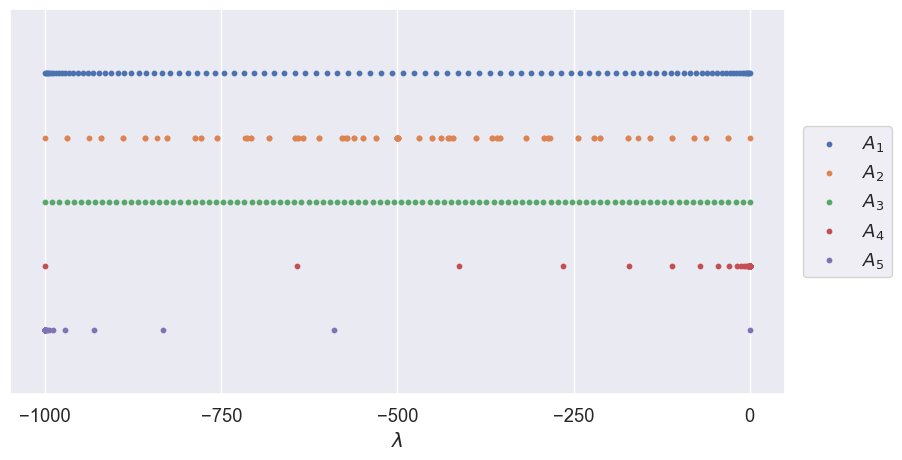

In [7]:
# Eigenvalue distribution

plot_eigenvalues(
    As=[A_LE[h]['A'] for h in [0.1, 0.07, 0.04]],
    legends=['$A_{LE}^{0.10}$', '$A_{LE}^{0.07}$', '$A_{LE}^{0.04}$'],
)

plot_eigenvalues(
    As=[A_LE[h]['H'] for h in [0.1, 0.07, 0.04]],
    legends=['$H_{LE}^{0.10}$', '$H_{LE}^{0.07}$', '$H_{LE}^{0.04}$'],
)

# The AAA algorithm

## What happens to `m` poles when $a \to -\infty$?

In [60]:
m = 10

nodes = []
poles_real = []
poles_imag = []
errors = []
ps = []
as_ = []
for a in tqdm([1e02, 1e03, 1e04, 1e05]):
    a = int(a)
    for p in [1, 3, 5]:
        f = Phi(p=p)
        Z = np.geomspace(-a, -1e-16, 20000)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        nodes.append(r.nodes)
        poles_real.append(r.poles().real)
        poles_imag.append(r.poles().imag)
        errors.append(e)
        ps.append(p)
        as_.append(a)

  0%|          | 0/4 [00:00<?, ?it/s]

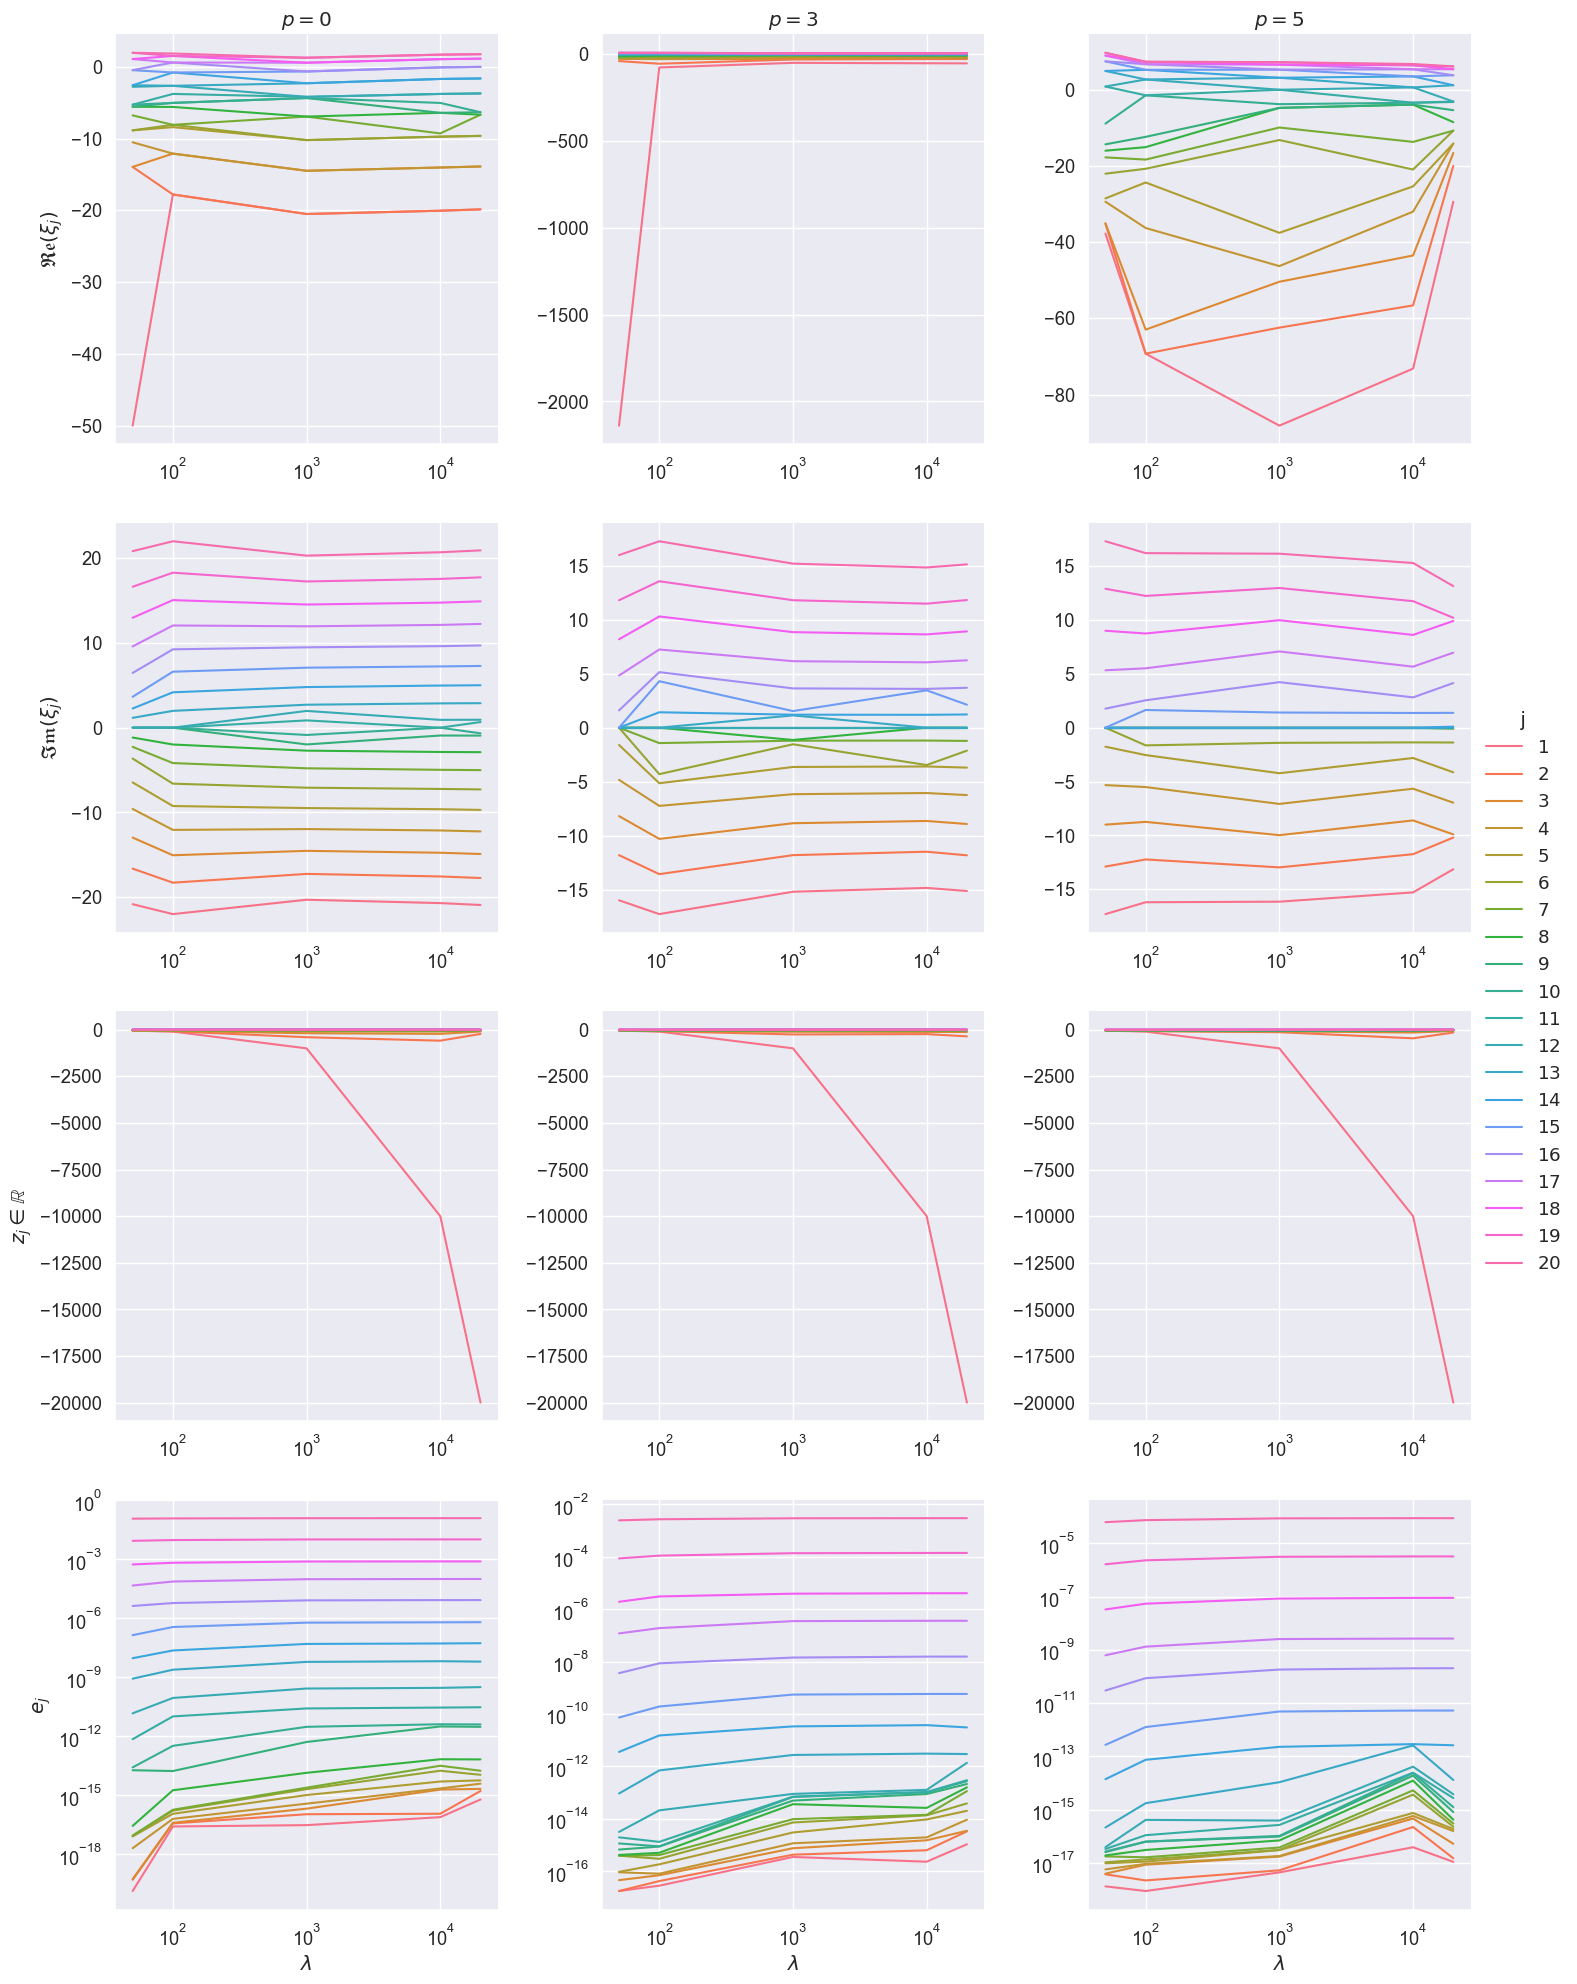

In [131]:
sort = True
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_j$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df_real = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
df_real['what'] = '$\\mathfrak{Re}(\\xi_j)$'
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df_imag = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
df_imag['what'] = '$\\mathfrak{Im}(\\xi_j)$'
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

errors_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in errors] for m in range(m)})
errors_['what'] = '$e_j$'
df_errors = pd.concat([data, errors_], axis=1)
df_errors = df_errors.melt(('a', 'p', 'what'), var_name='j', value_name='$\\xi$')

df = pd.concat([df_real, df_imag, df_nodes, df_errors])
df['a'] = df['a'].abs()
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='j',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', ylabel='')

ps_ = list(set(ps))
for i, axs in enumerate(fg.axes):
    for j, ax in enumerate(axs):
        if i == 0:
            ax.set(title=f'$p = {ps_[j]}$')
        else:
            ax.set(title='')
        if i == 3:
            ax.set(yscale='log')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_j)$');
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_j)$');
fg.axes[2, 0].set(ylabel='$z_j \\in \\mathbb{R}$');
fg.axes[3, 0].set(ylabel='$e_j$');

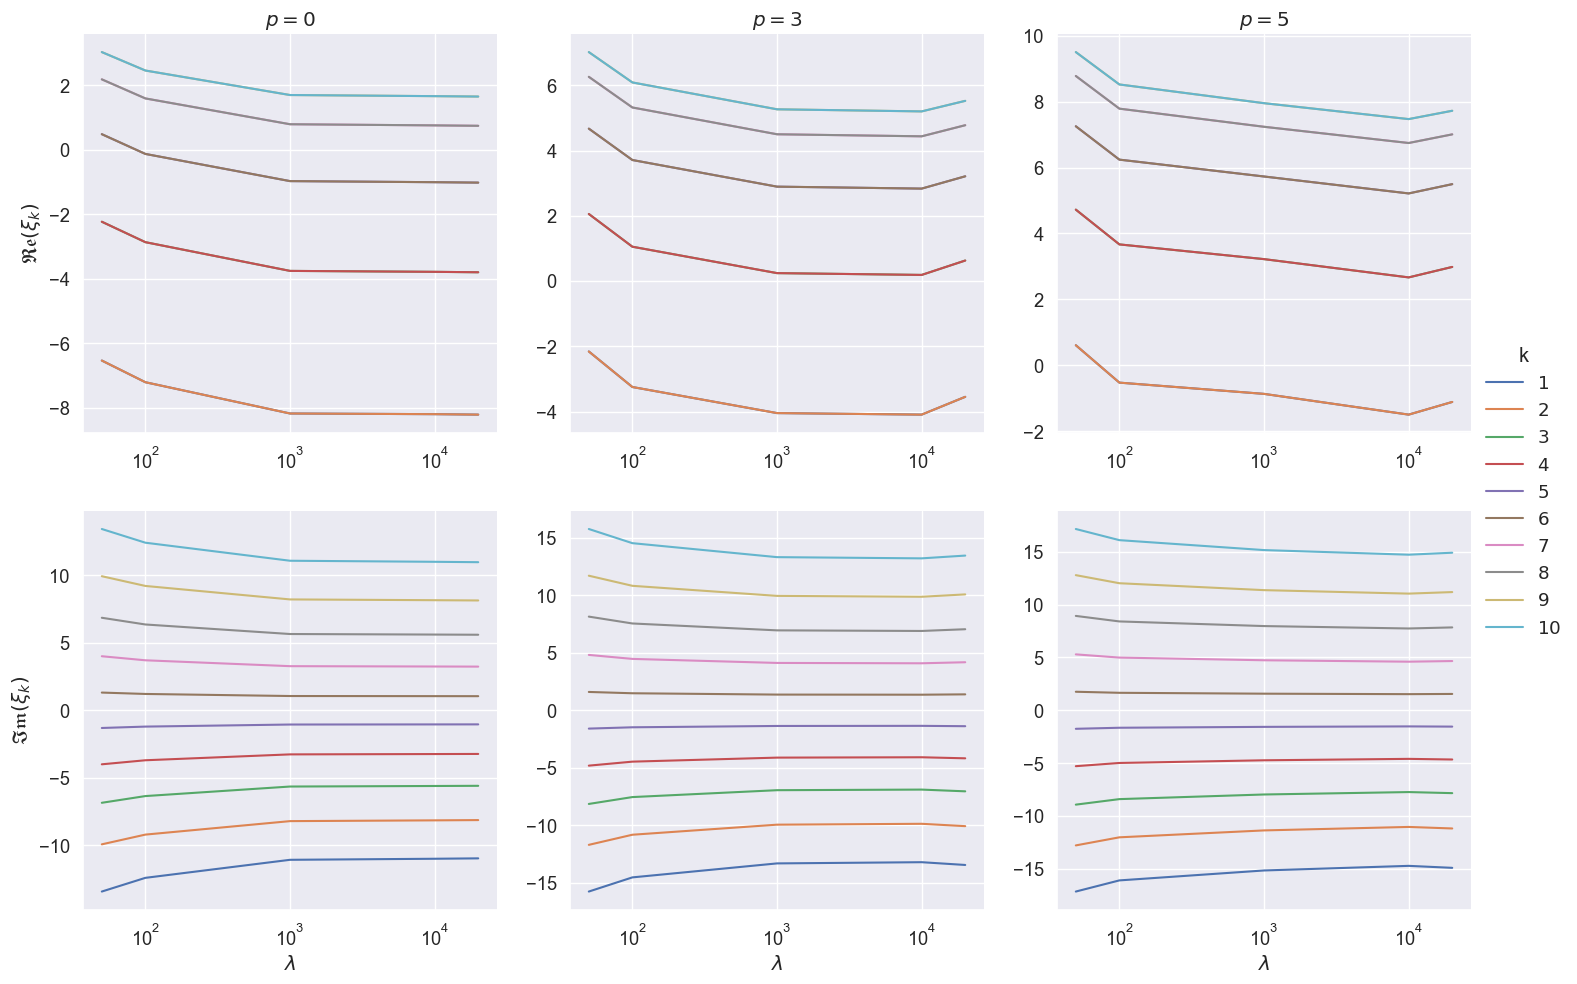

In [78]:
sort = True
data = pd.DataFrame({'a': as_, 'p': ps})

nodes_ = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in nodes] for m in range(m)})
nodes_['what'] = '$z_k$'
df_nodes = pd.concat([data, nodes_], axis=1)
df_nodes = df_nodes.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df_real = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_real] for m in range(m)})
df_real['what'] = '$\\mathfrak{Re}(\\xi_k)$'
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df_imag = pd.DataFrame({f'${m+1}$': [np.sort(p)[m] if sort else p[m] for p in poles_imag] for m in range(m)})
df_imag['what'] = '$\\mathfrak{Im}(\\xi_k)$'
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('a', 'p', 'what'), var_name='k', value_name='$\\xi$')

df = pd.concat([df_real, df_imag])
df['a'] = df['a'].abs()
# df = df[(df['p'] == 3)]
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='$\\xi$',
    hue='k',
    row='what',
    col='$p$',
    kind='line',
    facet_kws={'sharex': False, 'sharey': False},
)
fg.set(xscale='log', title='')

fg.axes[0, 0].set(ylabel='$\\mathfrak{Re}(\\xi_k)$');
fg.axes[1, 0].set(ylabel='$\\mathfrak{Im}(\\xi_k)$');
ps_ = [0, 3, 5]
for idx, ax in enumerate(fg.axes[0]):
    ax.set(title=f'$p={ps_[idx]}$');

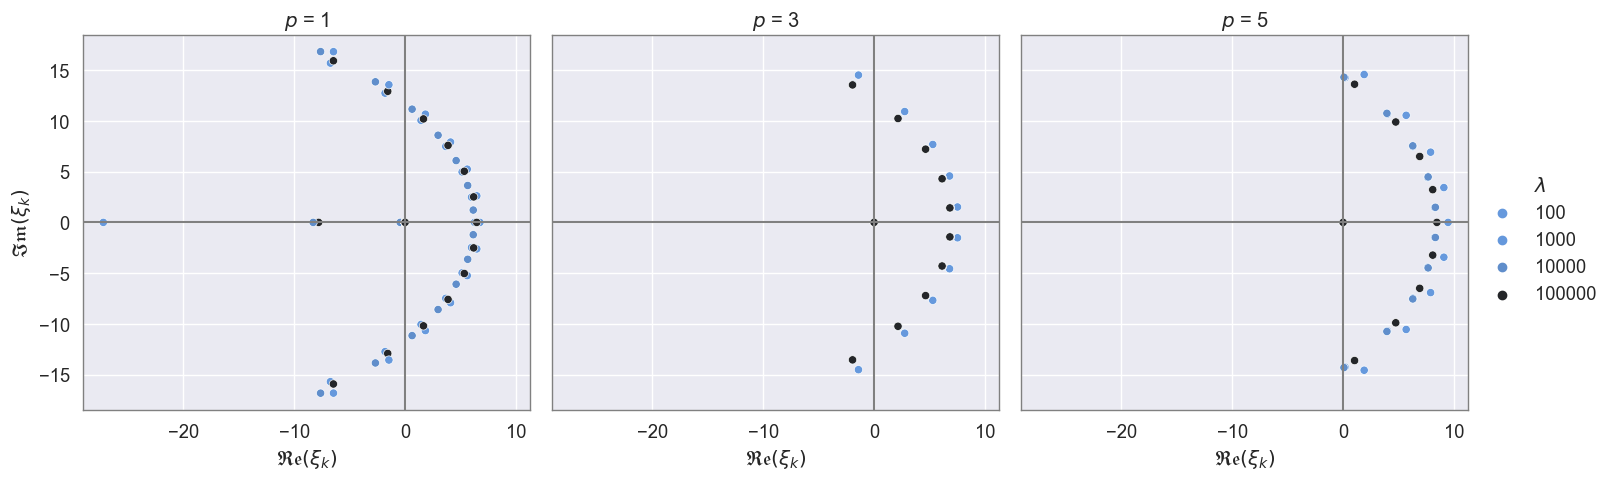

In [61]:
data = pd.DataFrame({'a': as_, 'p': ps})

df_real = pd.DataFrame({f'${m+1}$': [p[m] for p in poles_real] for m in range(m)})
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('a', 'p'), var_name='k', value_name='$\\mathfrak{Re}(\\xi_k)$')

df_imag = pd.DataFrame({f'${m+1}$': [p[m] for p in poles_imag] for m in range(m)})
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('a', 'p'), var_name='k', value_name='$\\mathfrak{Im}(\\xi_k)$')

df = df_real.merge(df_imag)
df['a'] = df['a'].abs()
fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\mathfrak{Re}(\\xi_k)$',
    y='$\\mathfrak{Im}(\\xi_k)$',
    hue='$\\lambda$',
    # style='k',
    col='$p$',
    kind='scatter',
    palette=sns.dark_palette("#69d", reverse=True, as_cmap=True),
    facet_kws={'sharex': True, 'sharey': True, 'despine': False},
)

for ax in fg.axes.flatten():
    ax.axhline(y=0, color='gray', linestyle='-')
    ax.axvline(x=0, color='gray', linestyle='-')
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

## What happens to the maximum error with different discretizations?

In [247]:
m = 20

ps = []
as_ = []
methods = []
errors = []
for p in tqdm([1, 3, 5]):
    f = Phi(p=p)
    approx = {}

    for n in [500, 1e03, 5e03, 1e04, 2e04]:
        n = int(n)
        Z = np.geomspace(-10000, -1e-16, int(n))
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        approx[f'geomspace($-10^{4}$, $-\\epsilon$, ${n}$)'] = {'r': r, 'e': e}

        for a in np.geomspace(1e02, 1e05, 3):
            Z_err = np.linspace(-a, 0, int(2 * a))

            for key, val in approx.items():
                ps.append(p)
                as_.append(a)
                errors.append(np.abs(f.scalar(Z_err) - val['r'](Z_err)).max())
                methods.append(key)


  0%|          | 0/3 [00:00<?, ?it/s]

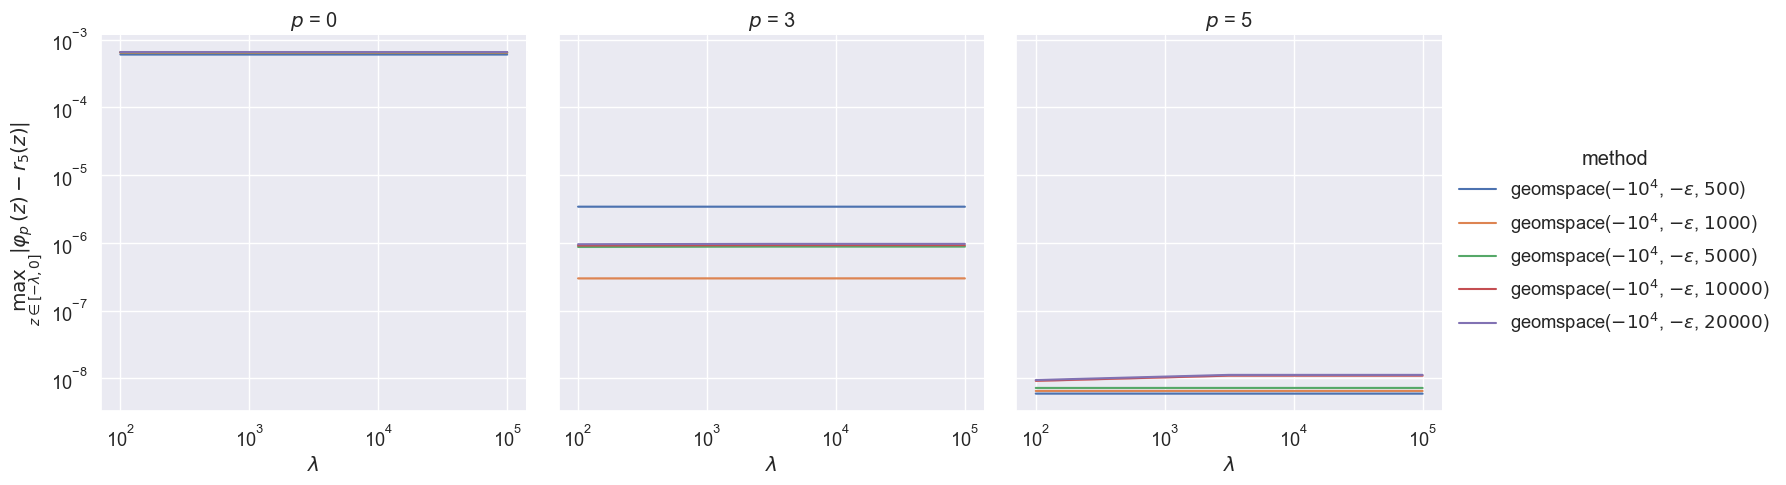

In [248]:
data = pd.DataFrame({'a': as_, 'p': ps, 'e': errors, 'method': methods})
df = data

fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\lambda$',
    y='e',
    hue='method',
    col='$p$',
    kind='line',
    facet_kws={'sharex': True, 'sharey': True},
)
fg.set(xscale='log', yscale='log', ylabel='')

fg.axes[0, 0].set(ylabel=f'$\\max_{{z \\in [-\\lambda, 0]}} |\\varphi_p(z) - r_{{{m}}}(z)|$');

## What happens to the maximum error when m is increased?

In [71]:
ms = []
ps = []
as_ = []
errors = []

Z = np.geomspace(-1e04, -1e-16, int(30e03))

for m in [int(m) for m in [1, 4, 8, 12, 15, 20, 25, 30, 40]]:
    for p in tqdm([1, 3, 5], desc=f'm={m}'):
        f = Phi(p=p)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        for a in [1e03, 1e04, 1e05]:
            a = int(a)
            Z_err = np.linspace(-a, 0, (2 * a))
            ps.append(p)
            as_.append(a)
            ms.append(m)
            errors.append(np.abs(f.scalar(Z_err) - r(Z_err)).max())


m=1:   0%|          | 0/3 [00:00<?, ?it/s]

m=4:   0%|          | 0/3 [00:00<?, ?it/s]

m=8:   0%|          | 0/3 [00:00<?, ?it/s]

m=12:   0%|          | 0/3 [00:00<?, ?it/s]

m=15:   0%|          | 0/3 [00:00<?, ?it/s]

m=20:   0%|          | 0/3 [00:00<?, ?it/s]

m=25:   0%|          | 0/3 [00:00<?, ?it/s]

m=30:   0%|          | 0/3 [00:00<?, ?it/s]

m=40:   0%|          | 0/3 [00:00<?, ?it/s]

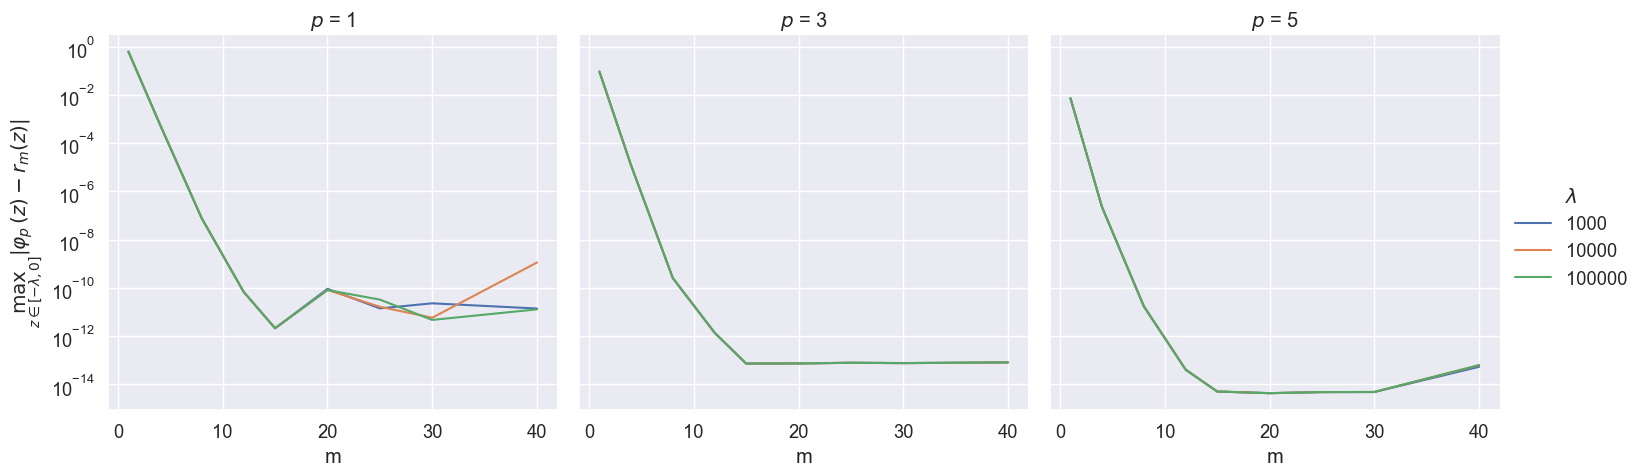

In [72]:
data = pd.DataFrame({'a': as_, 'p': ps, 'e': errors, 'm': ms})
df = data

fg = sns.relplot(
    data=df.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='m',
    y='e',
    hue='$\\lambda$',
    col='$p$',
    kind='line',
    facet_kws={'sharex': True, 'sharey': True},
    # legend='brief',
    palette='deep',
)
fg.set(yscale='log', ylabel='')

fg.axes[0, 0].set(ylabel=f'$\\max_{{z \\in [-\\lambda, 0]}} |\\varphi_p(z) - r_m(z)|$');

## What happens to the poles when m is increased?

In [62]:
p = 3
f = Phi(p=p)

ms = [5, 10, 15, 20, 25, 30, 40, 50]
ns = [20e03, 30e03]

dfs = []
for n in ns:
    n = int(n)

    nodes, poles_real, poles_imag, errors = [], [], [], []
    for m in tqdm(ms):
        Z = np.linspace(-1e04, 0, n)
        r, e = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=True)
        nodes.append(r.nodes)
        poles_real.append(r.poles().real)
        poles_imag.append(r.poles().imag)
        errors.append(e)

    dfs_=[]
    for idx, m in enumerate(ms):
        dfs_.append(pd.DataFrame({'n': n, 'm': m, '$\\mathfrak{Re}(\\xi_k)$': poles_real[idx], '$\\mathfrak{Im}(\\xi_k)$': poles_imag[idx]}))
    dfs.append(pd.concat(dfs_))

df = pd.concat(dfs)

  0%|          | 0/3 [00:00<?, ?it/s]

[(-45.0, 10.0)]

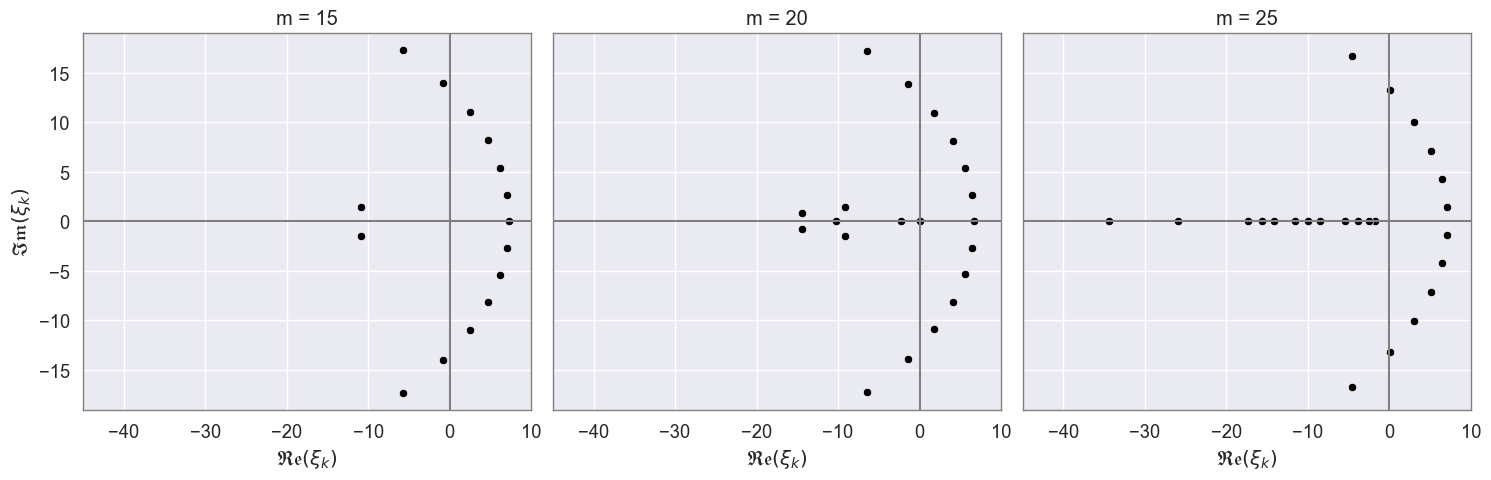

In [63]:
df_ = df

df_ = df_[
    (df['m'] == 15)
    | (df['m'] == 20)
    | (df['m'] == 25)
]

fg = sns.relplot(
    data=df_.rename(columns={'p': '$p$', 'a': '$\\lambda$'}),
    x='$\\mathfrak{Re}(\\xi_k)$',
    y='$\\mathfrak{Im}(\\xi_k)$',
    # hue='n',
    col='m',
    # col_wrap=4,
    kind='scatter',
    color='black',
    # palette='deep',
    facet_kws={'sharex': True, 'sharey': True, 'despine': False},
)

for ax in fg.axes.flatten():
    ax.axhline(y=0, color='gray', linestyle='-')
    ax.axvline(x=0, color='gray', linestyle='-')
    # ax.set(xlim=[-20, 10])
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)
fg.axes[0, -1].set(xlim=[-45, 10])

## Store the poles for different phi-functions

In [73]:
for p in tqdm([0, 1, 3, 5, 10]):
    for m in [1, 3, 5, 10, 15, 20, 25, 30, 40]:
        f = Phi(p=p)

        n = int(30e03)
        Z = np.geomspace(-1e04, -1e-16, n)
        r = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1, return_errors=False)
        with open(f'data/poles/p{p:02d}_m{m:03d}.npy', 'wb') as f:
            np.save(f, r.poles())

  0%|          | 0/5 [00:00<?, ?it/s]

# Experiments

## With test matrices

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mmax_PA = 200
mmax_RA = 100
# ns = [n ** 2 for n in range(100, 0, -10)]
ns = [n ** 2 for n in [60]]
as_ = [1e+03, 1e+04, 1e+05]
n_matrices = 1
ps = [0, 1, 3, 5]
nms = 30

dfs_ = []
pbar_n = tqdm(total=len(ns), desc='Sizes (n)', leave=True)
for n in ns:
    pbar_n.desc = f'Sizes (n={n})'
    pbar_n.refresh()

    # Get random vector v and normalize it
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)

    # Set the name of the test matrices
    names = ['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$']

    # Get the eigenvalues of A1 and A2
    eigs = {}
    A1 = get_FD_matrix(n=n, d=1, scale=False)
    eigs['A1'] = (
        sps.linalg.eigsh(A1, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A1, k=1, which='LA', return_eigenvectors=False).item(),
    )
    A2 = get_FD_matrix(n=(n ** .5), d=2, scale=False)
    eigs['A2'] = (
        sps.linalg.eigsh(A2, k=1, which='SA', return_eigenvectors=False).item(),
        sps.linalg.eigsh(A2, k=1, which='LA', return_eigenvectors=False).item(),
    )

    pbar_a = tqdm(total=len(as_), desc='Eigenvalues (a)', leave=False)
    for a in as_:
        pbar_a.desc = f'Eigenvalues (a={a:.0e})'
        pbar_a.refresh()

        interval = (-a, 0)
        matrices = get_test_matrices(n=n, interval=interval, eigs=eigs)
        intervals = [interval] * 5

        # Get convergence data for the test matrices
        pbar_A = tqdm(total=n_matrices, desc='Matrices (A)', leave=False)
        for name, A, interval in zip(names[:n_matrices], matrices[:n_matrices], intervals[:n_matrices]):
            pbar_A.desc = f'Matrices (A={name})'
            pbar_A.refresh()

            pbar_p = tqdm(total=len(ps), desc='Phi-function (p)', leave=False)
            for p in ps:
                pbar_p.desc = f'Phi-function (p={p})'
                pbar_p.refresh()
                d = get_convergence(
                    A=A,
                    v=v,
                    nms=nms,
                    funcs=[
                        Phi(p=p)
                        # Cosine(t=t),
                        # Sine(t=t),
                        # Sinc(t=t),
                        # Sinc2(t=t)
                    ],
                    ks=[1, 3, 5, 10],  # TODO: Add 15, 20, 25, 30
                    mmax_PA=min(n - 20, mmax_PA),
                    mmax_RA=min(n - 20, mmax_RA),
                    interval=interval,
                    poles_dir='./data/poles/',
                )
                d['name'] = [name] * len(d['err'])
                d['n'] = [n] * len(d['err'])
                d['a'] = [f'{a:.0e}'] * len(d['err'])
                d['p'] = [f'{p}'] * len(d['err'])
                dfs_.append(pd.DataFrame(d))
                pbar_p.update()

            pbar_p.close()
            pbar_A.update()

        pbar_A.close()
        pbar_a.update()

    pbar_a.close()
    pbar_n.update()

pbar_n.close()

# Build the dataframe and save it
df = pd.concat(dfs_)
df.to_csv('experiments_tmp.csv', index=False)

warnings.filterwarnings('default')
print('Done!')

## With the linear elasticity matrices

In [ ]:
import warnings
warnings.filterwarnings('ignore')

mmax_PA = 400
mmax_RA = 400
ts = [
    5e-05,
    1e-04,
    1e-03,
    1e-01,
    # 1e-00
]
nms = 30

# Set the test matrices
hs = [
    0.04,
    0.07,
    0.1,
]
names = [f'$H_{{LE}}^{{h={h:.2f}}}$' for h in hs]
matrices = [A_LE[h]['H'].toarray() for h in hs]
vectors = [(A_LE[h]['u0'], A_LE[h]['v0'], A_LE[h]['b']) for h in hs]
intervals = [(A_LE[h]['dH'].min(), A_LE[h]['dH'].max()) for h in hs]

dfs_ = []
pbar_A = tqdm(total=len(matrices), desc='Matrices (A)', leave=True)
for name, A, vectors, interval in zip(names, matrices, vectors, intervals):
    pbar_A.desc = f'Matrices (A={name})'
    pbar_A.refresh()

    # Get random vector v and normalize it
    n = A.shape[0]
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    u0, v0, b0 = vectors

    pbar_p = tqdm(total=len(ts), desc='Time steps (t)', leave=False)
    for t in ts:
        pbar_p.desc = f'Time steps (t={t:.0e})'
        pbar_p.refresh()
        d = get_convergence(
            A=A,
            v=v,
            nms=nms,
            funcs=[
                Cosine(t=t),
                Sine(t=t),
                Sinc(t=t),
                Sinc2(t=t)
            ],
            mmax_PA=min(n-20, mmax_PA),
            mmax_RA=min(n-20, mmax_RA),
            interval=interval,
        )
        d['name'] = [name] * len(d['err'])
        d['n'] = [n] * len(d['err'])
        d['t'] = [f'{t:.0e}'] * len(d['err'])
        dfs_.append(d)

        pbar_p.update()

    pbar_p.close()
    pbar_A.update()

pbar_A.close()

# Build the dataframe and save it
df = pd.concat(dfs_)
df.to_csv('experiments_tmp.csv', index=False)

warnings.filterwarnings('default')
print('Done!')

## Store/load of the results

In [10]:
# Save the experiments
df.to_csv('trigfuncs.csv', index=False)

In [13]:
# Load the experiments
df = pd.read_csv('trigfuncs.csv')

# Plots

## Convergence of trigonometric functions

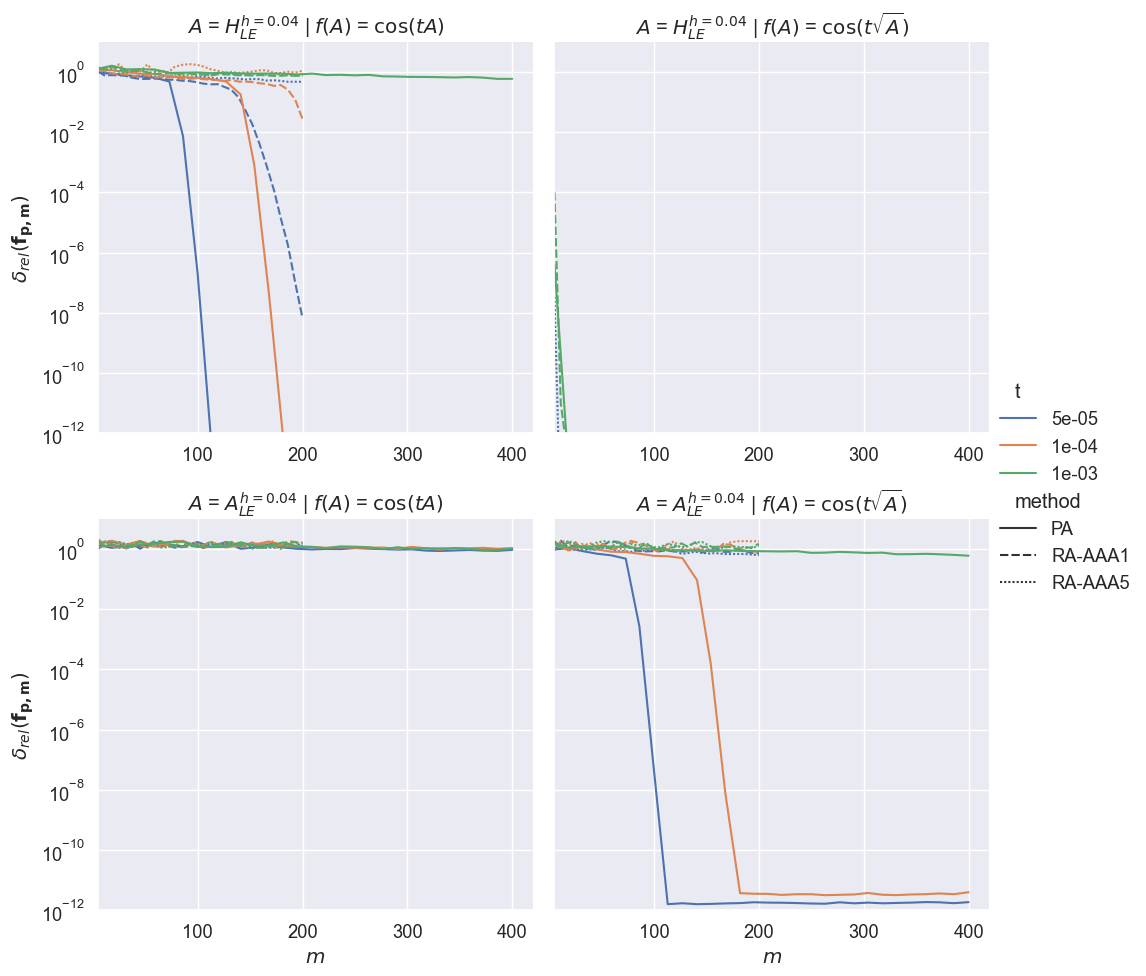

In [12]:
data = df[
    # Method
    ((df['method'] != 'EX'))
    # & ((df['method'] == 'PA') | (df['method'] == 'RA-AAA1'))
    # &((df['name'] == '$A_2$'))
]

# data.loc[data['f'] == '$cos(tA)$', 'f'] = '$\\cos(t\\sqrt{A})$'
# data.loc[data['f'] == '$t sinc(tA)$', 'f'] = '$t \\mathrm{sinc}(t\\sqrt{A})$'
# data.loc[data['f'] == '$\\frac{t^2}{2} sinc(\\frac{t}{2} A)^2$', 'f'] = '$\\frac{t^2}{2} \\mathrm{sinc}^2(\\frac{t}{2} \\sqrt{A})$'
# data.loc[data['t'] == 5e-05, 't'] = '5e-05'
# data.loc[data['t'] == 1e-04, 't'] = '1e-04'
# data.loc[data['t'] == 1e-03, 't'] = '1e-03'


fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'm': '$m$', 'f': '$f(A)$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='t',
    # row='$A$',
    col='$f(A)$',
    style='method',
    row='$A$',
    palette='deep',
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\mathbf{f_{p, m}})$',
)

## Convergence for different $\varphi$-functions

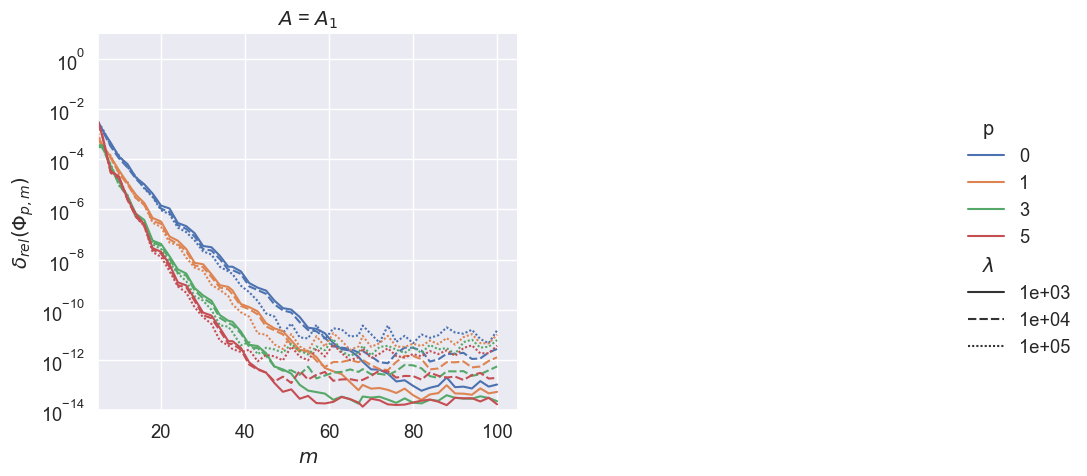

In [7]:
data = df[
    ((df['method'] == 'RA-ONES'))
    & ((df['name'] != 'bound'))
    & (df['n'] == 10000)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    style='$\\lambda$',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-14, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);

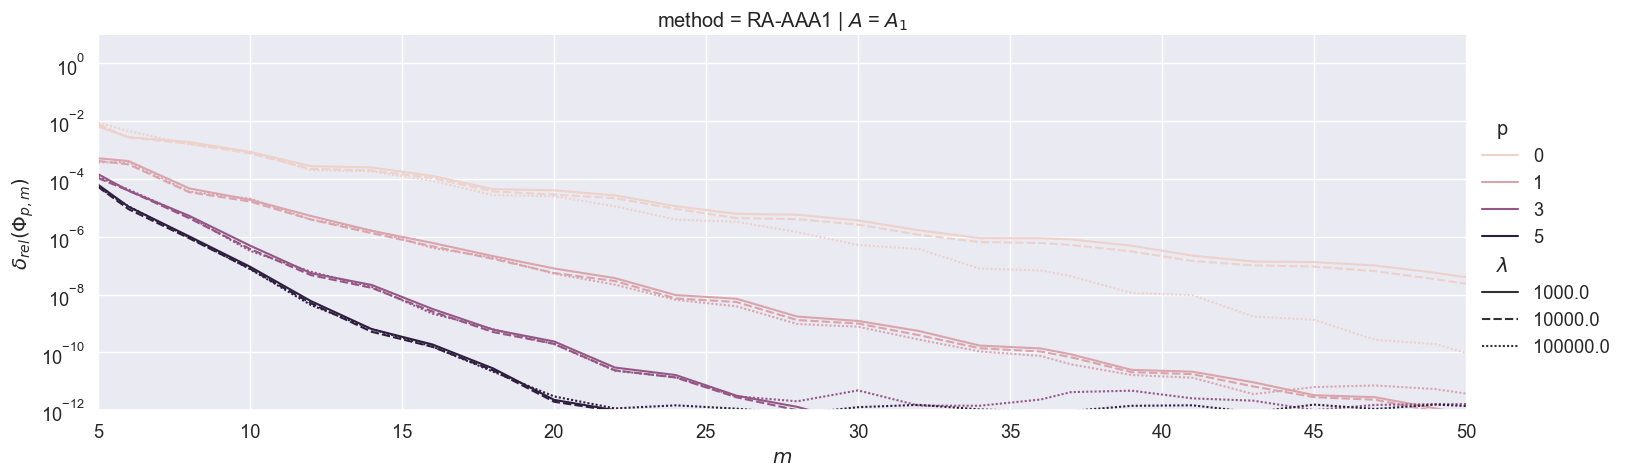

In [15]:
data = df[
    # phi functions
    (df['p'] != 10)

    # Method
    & ((df['method'] == 'RA-AAA1'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    # & ((df['a'] == 10000) | (df['a'] == 5000) | (df['a'] == 1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 3600) & (df['m'] > 300))
    # & (df['m'] < 600)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='p',
    col='$A$',
    row='method',
    style='$\\lambda$',
    # col_wrap=2,
    facet_kws={'sharex': False},
    height=5,
    aspect=3,
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
);
fg.axes[0, 0].set(xlim=[5, 50]);

## Convergence for different matrices

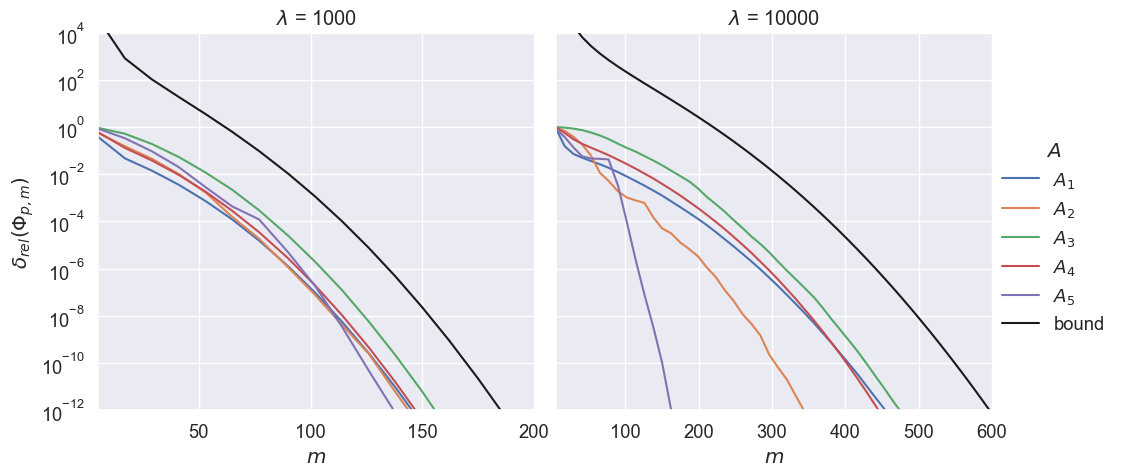

In [15]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & ((df['n'] == 10000))

    # Smallest eigenvalue
    & ((df['a'] == 10000) | (df['a'] == 1000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='$A$',
    # style='p',
    col='$\\lambda$',
    col_wrap=2,
    hue_order=['$A_1$', '$A_2$', '$A_3$', '$A_4$', '$A_5$', 'bound'],
    col_order=[1000, 10000],
    facet_kws={'sharex': False},
    palette=['C0', 'C1', 'C2', 'C3', 'C4', 'k'],
)
ax = plt.gca()
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+04],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
);
fg.axes[0].set(xlim=[5, 200]);
fg.axes[1].set(xlim=[5, 600]);

## Convergence with different methods

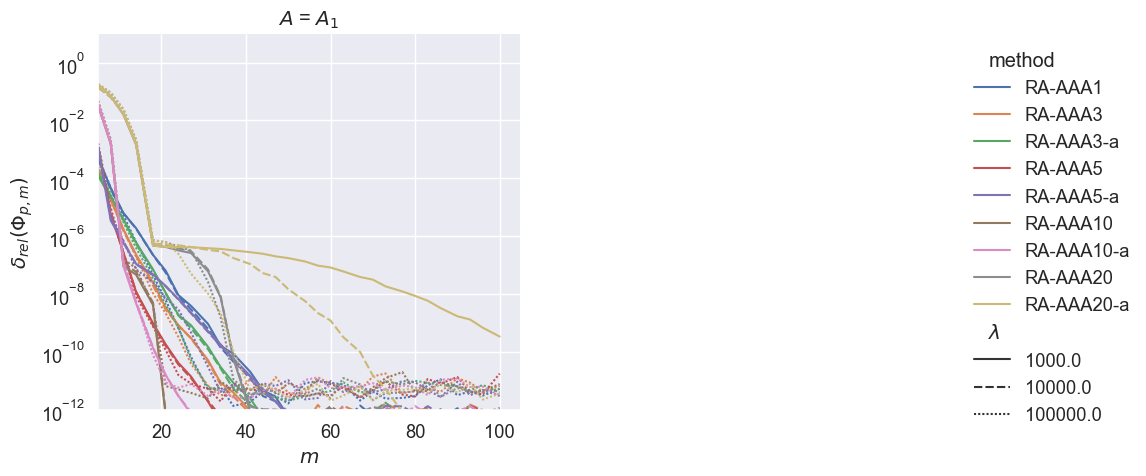

In [6]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & ((df['method'] != 'EX') & (df['method'] != 'PA'))

    # Matrices
    # & ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))

    # Size
    & (df['n'] == 3600)

    # Smallest eigenvalue
    # & ((df['a'] == -10000) | (df['a'] == -5000) | (df['a'] == -1000))

    # Custom
    # & ~((df['name'] == '$A_2$') & (df['n'] == 900) & (df['m'] > 200))
    # & (df['m'] < 300)
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    style='$\\lambda$',
    col='$A$',
    hue='method',
    col_wrap=2,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\Phi_{p, m})$',
)
# fg.axes[0].set(xlim=[5, 60])
# fg.axes[1].set(xlim=[5, 30])
# fg.axes[2].set(xlim=[5, 40])
# fg.axes[3].set(xlim=[5, 60])
# fg.axes[4].set(xlim=[5, 20])

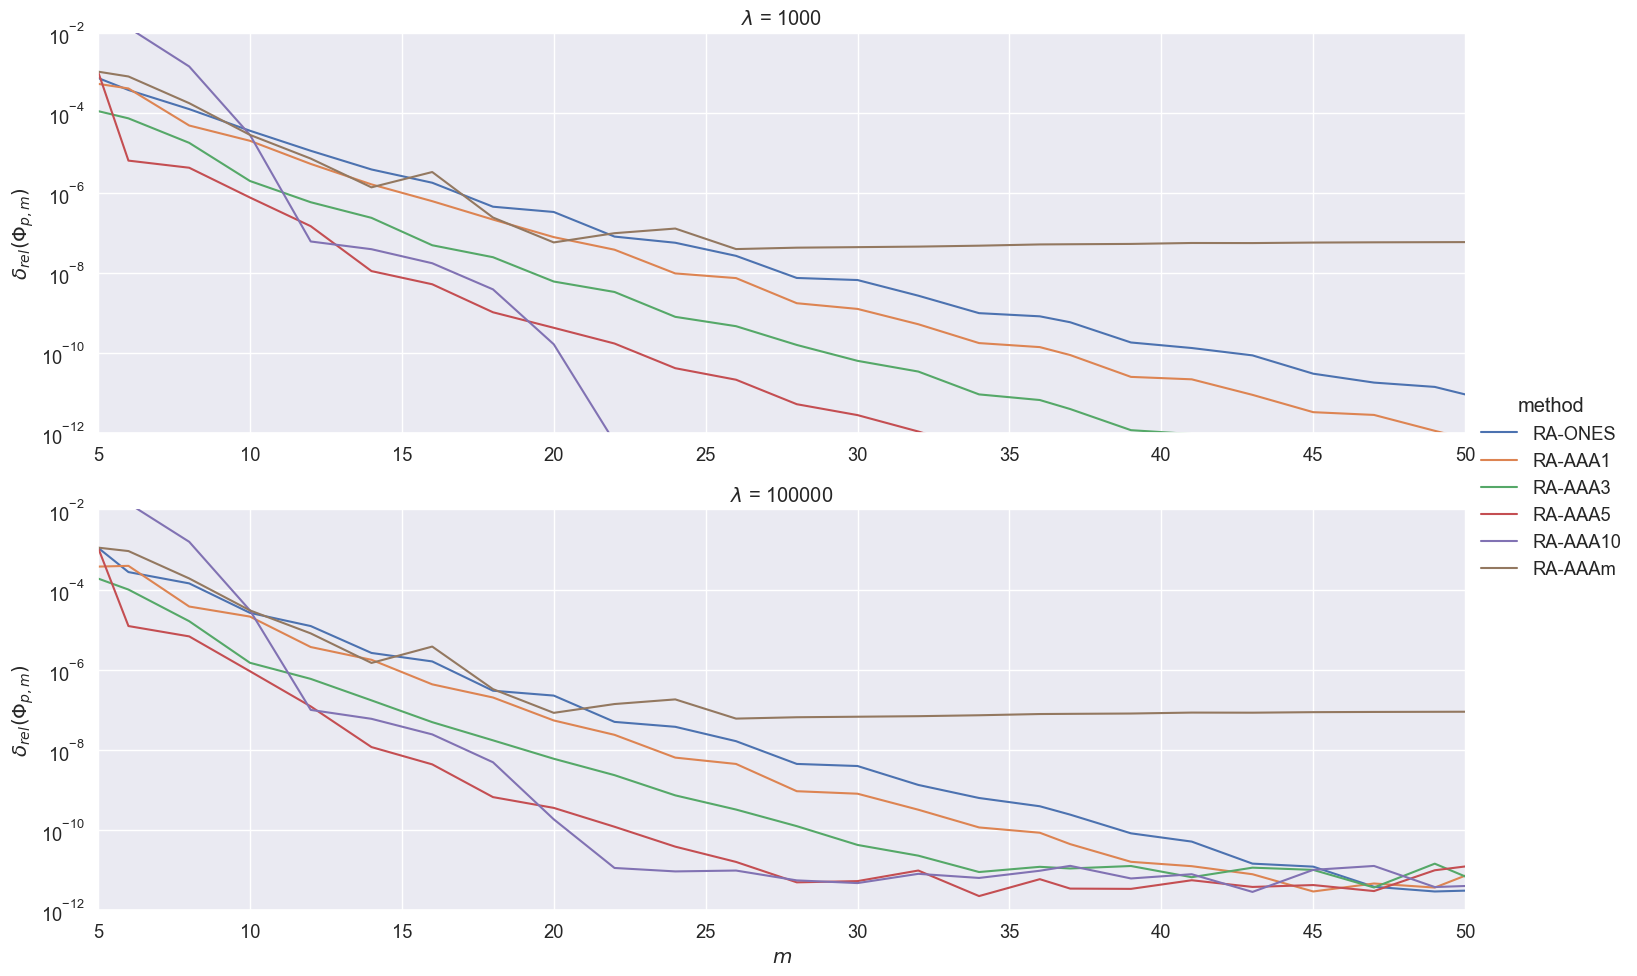

In [15]:
data = df[
    # phi functions
    (df['p'] == 1)

    # Method
    & (((df['method'].str.contains('AAA'))) | (df['method'] == 'RA-ONES'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    & (df['n'] == 10000)

    # Smallest eigenvalue
    & ((df['a'] == 100000) | (df['a'] == 1000))
].copy()

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    row='$\\lambda$',
    # col='$A$',
    hue='method',
    # col_wrap=2,
    height=5,
    aspect=3,
    facet_kws={'sharex': False},
)
fg.set(
    yscale='log',
    xlim=[5, 50],
    ylim=[1e-12, 1e-02],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## Convergence with different n

Show that RA has mesh-independent convergence, whereas PA does not. Cite the review paper of Guttel for that.

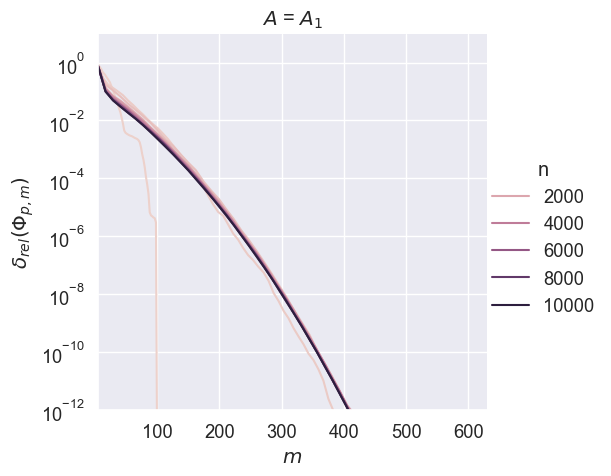

In [130]:
data = df[
    # phi functions
    (df['p'] == 3)

    # Method
    & ((df['method'] == 'PA'))

    # Matrices
    & ((df['name'] == '$A_1$'))

    # Size
    # & (df['n'] == 3600)

    # Smallest eigenvalue
    & ((df['a'] == 10000))
]

fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'a': '$\\lambda$', 'm': '$m$'}),
    x='$m$',
    y='err',
    kind='line',
    hue='n',
    # col='method',
    row='$A$',
    # col_wrap=2,
    # facet_kws={'sharex': False}
)
fg.set(
    yscale='log',
    xlim=[5, None],
    ylim=[1e-12, 1e+01],
    ylabel='$\delta_{rel}(\Phi_{p, m})$',
)

## CPU time with different n

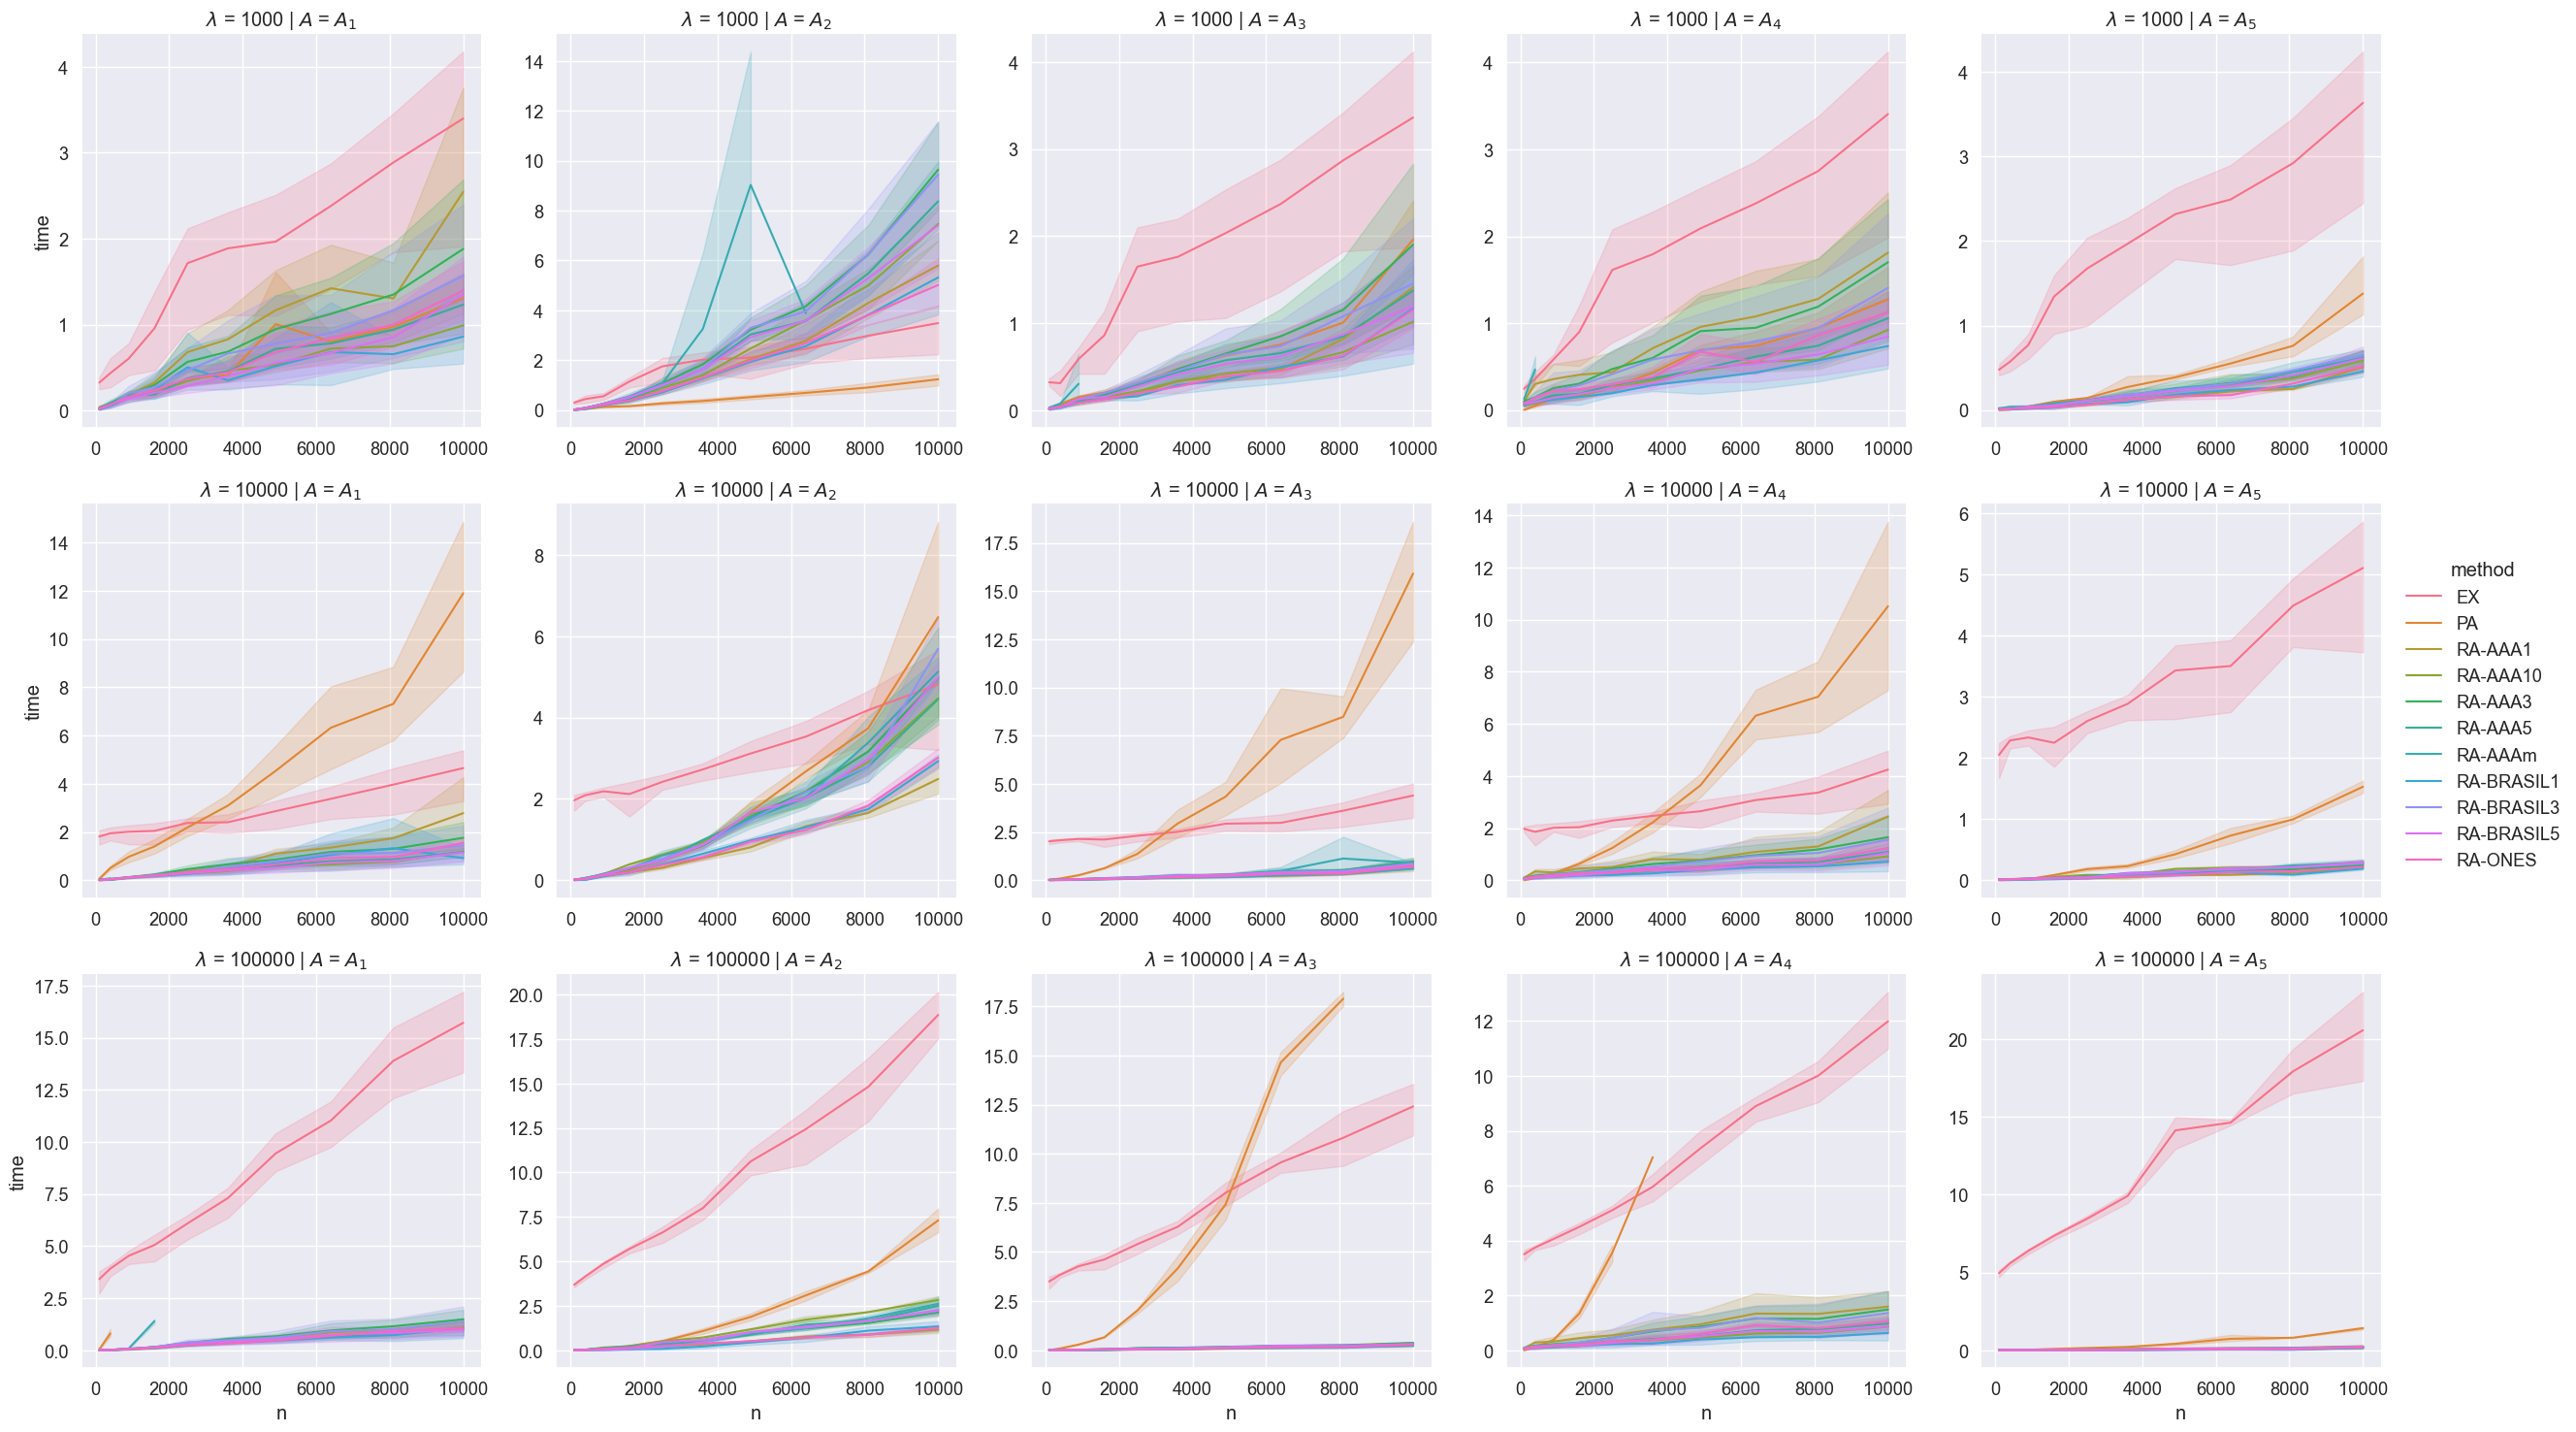

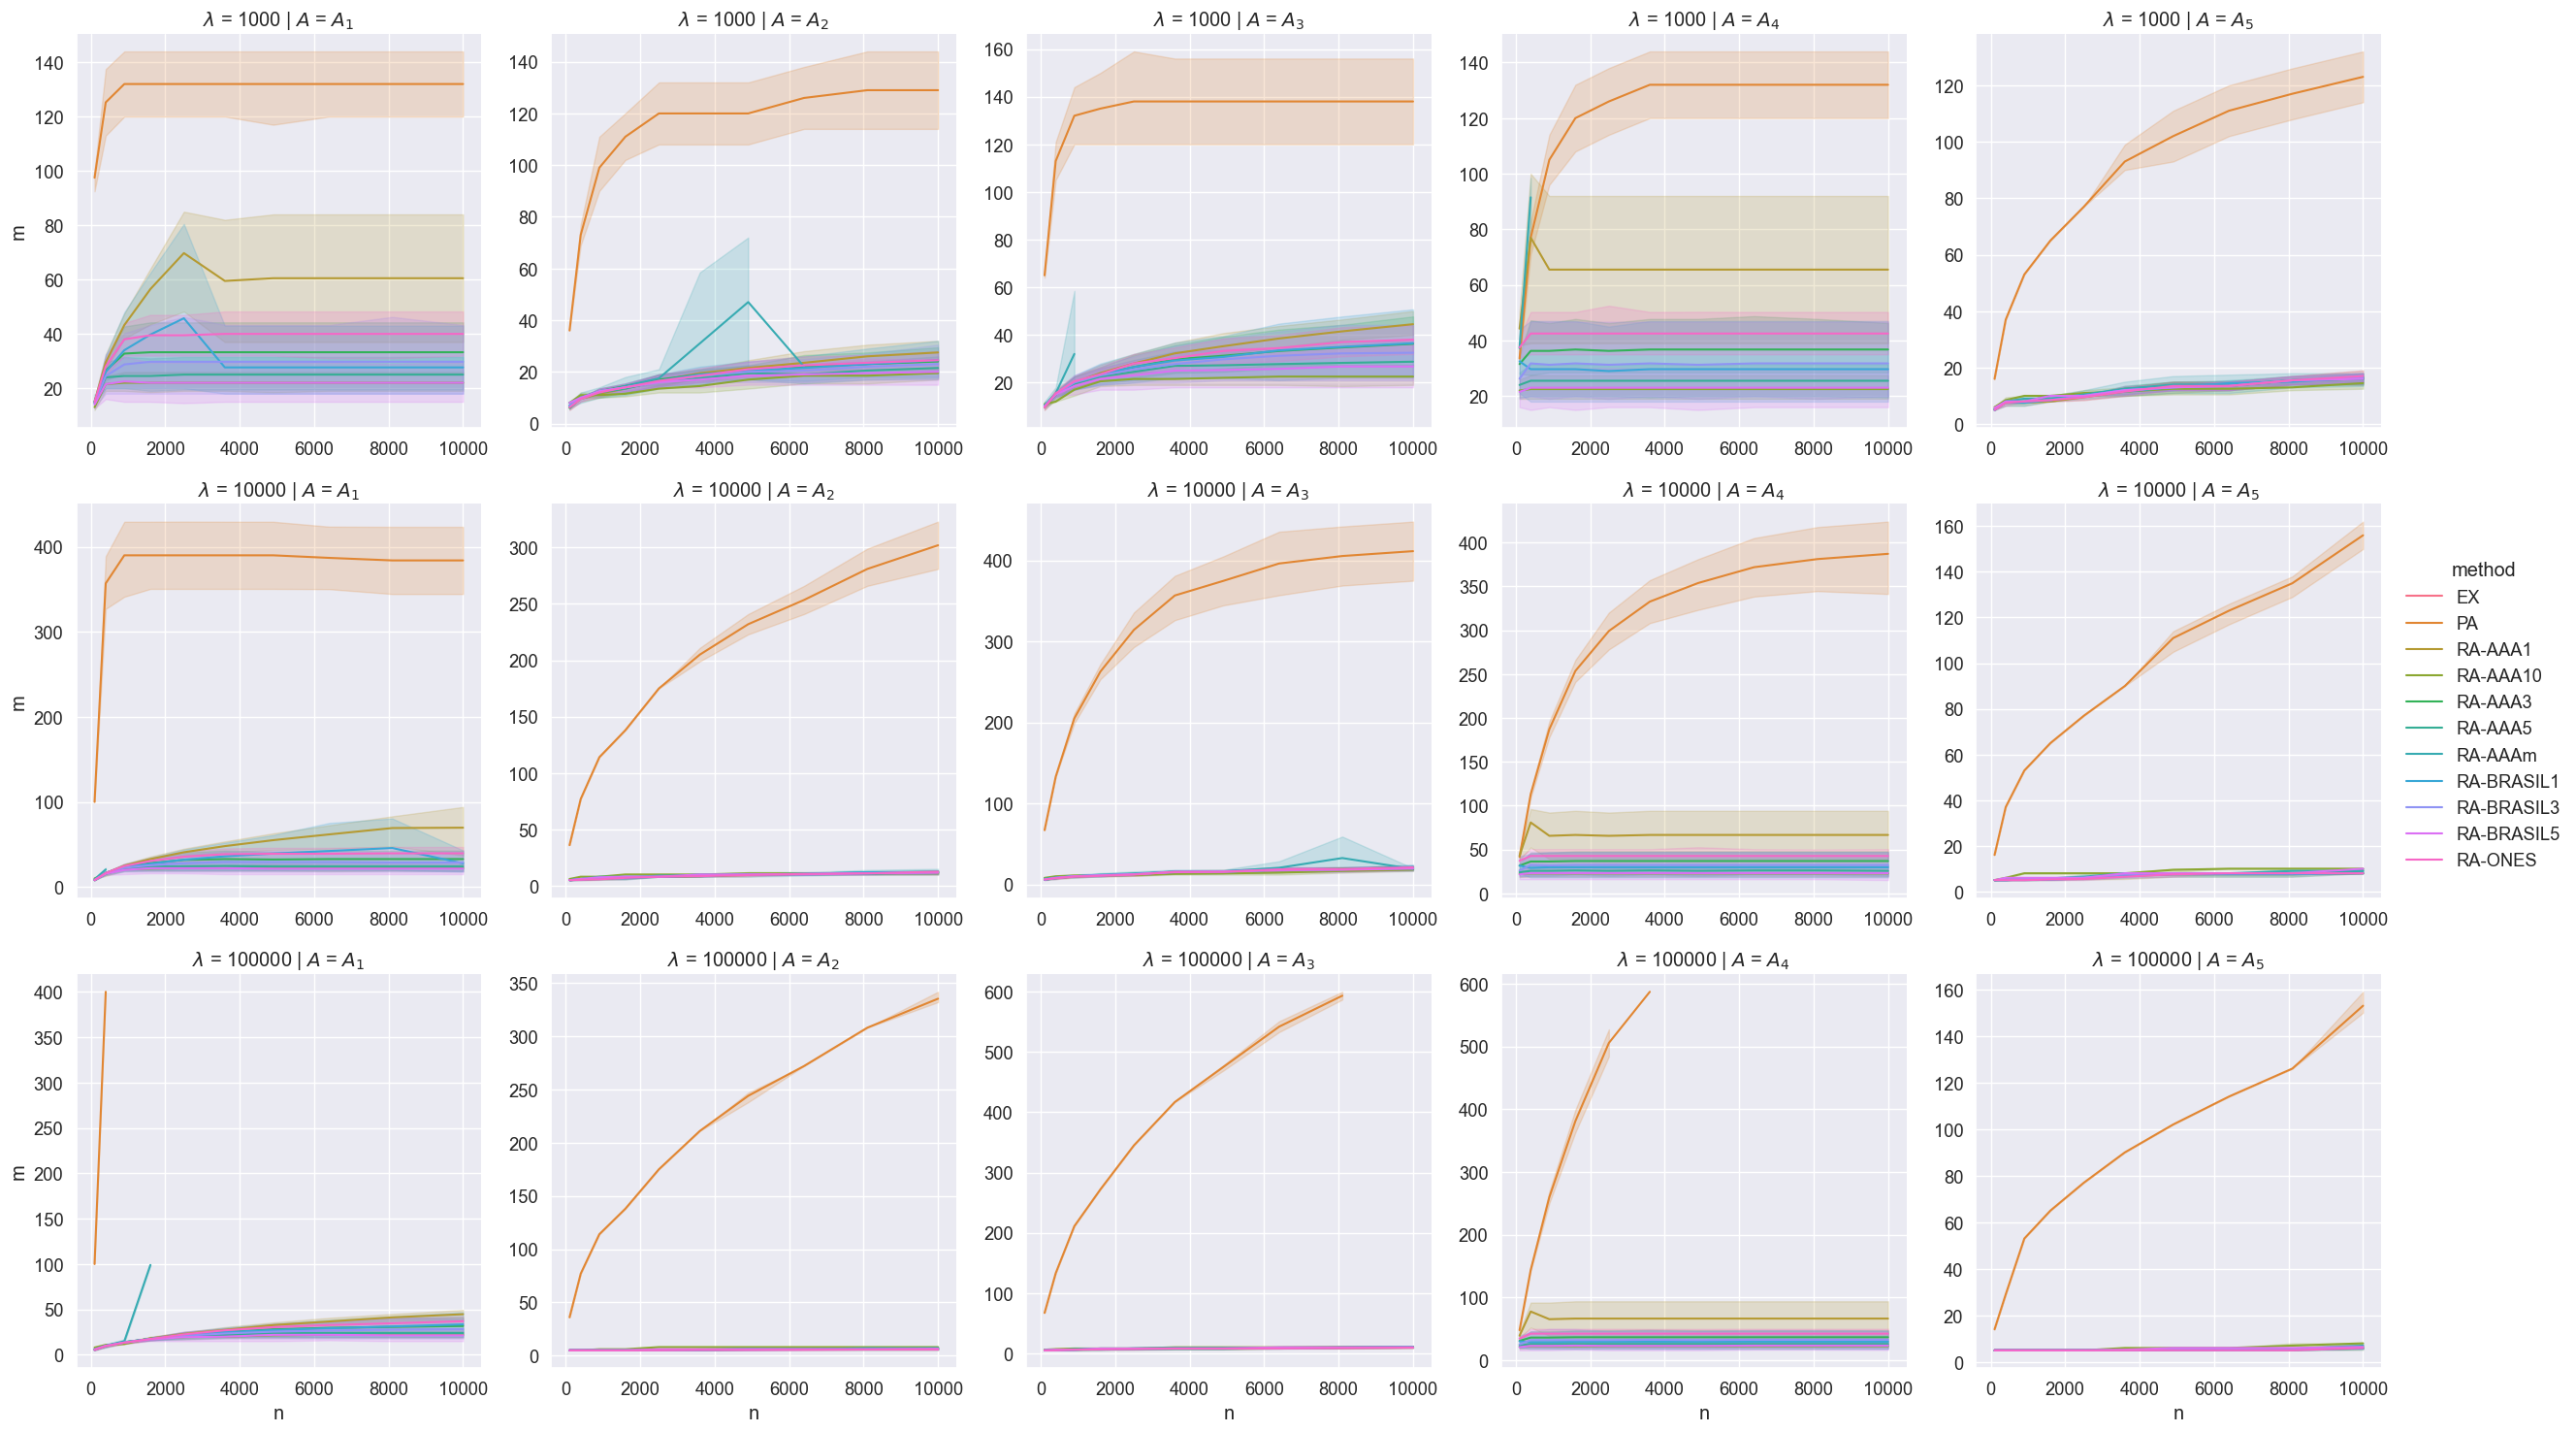

In [146]:
data = df[
    ((df['name'] != 'bound'))
    # & ((df['p'] == 5))
    # & ((df['method'].str.contains('RA')))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)

# Plot CPU time
fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

# Plot smallest m
fg = sns.relplot(
    data=data,
    x='n',
    y='m',
    kind='line',
    hue='method',
    col='$A$',
    row='$\\lambda$',
    facet_kws={'sharex': False, 'sharey': False}
)

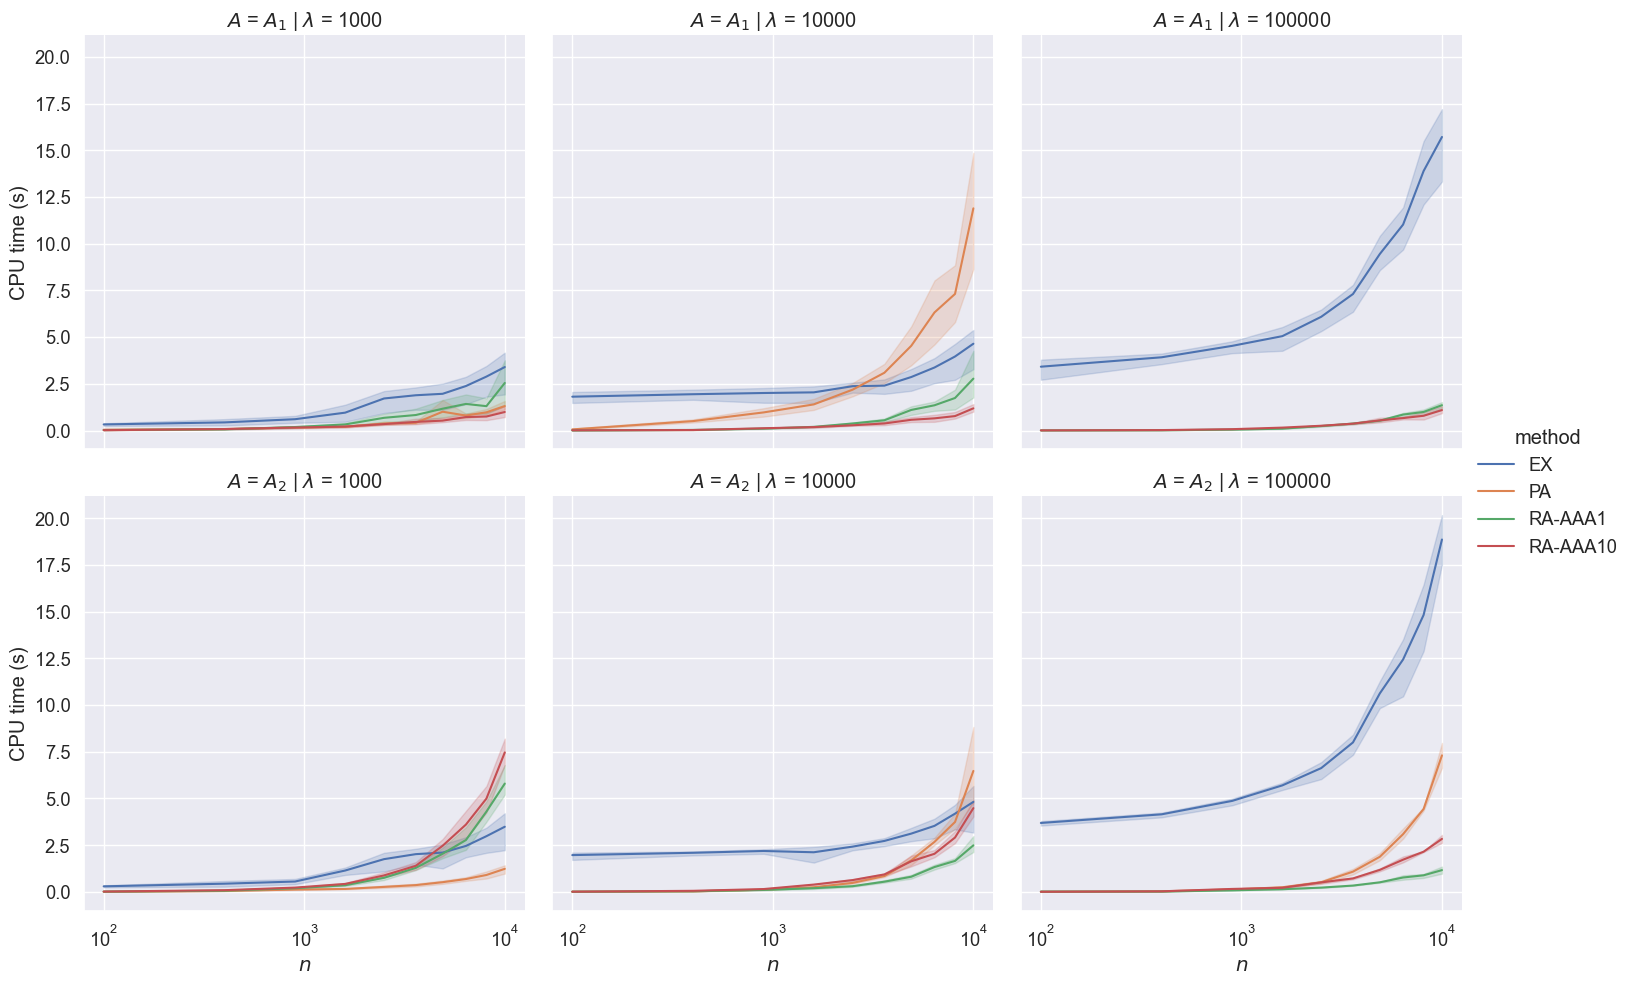

In [158]:
data = df[
    ((df['name'] == '$A_1$') | (df['name'] == '$A_2$'))
    & ((df['method'] == 'EX') | (df['method'] == 'PA') | (df['method'] == 'RA-AAA1') | (df['method'] == 'RA-AAA10'))
    & ~((df['a'] == 100000) & (df['method'] == 'PA') & (df['name'] == '$A_1$'))
]

thresh = 1e-10
data = data.rename(columns={'name': '$A$', 'a': '$\\lambda$'})
data = data[data['err'] < thresh].groupby(['method', '$\\lambda$', 'p', '$A$', 'n']).aggregate(np.min)


fg = sns.relplot(
    data=data,
    x='n',
    y='time',
    kind='line',
    hue='method',
    row='$A$',
    col='$\\lambda$',
    col_order=[1000, 10000, 100000],
    # facet_kws={'sharey': False}
)
fg.set(
    xscale='log',
    ylabel='CPU time (s)',
    xlabel='$n$',
)